## New Machine Setup

In [ ]:
## Run it only for 1st time machine setup
# %pip install nibabel scipy numpy scikit-learn tensorflow matplotlib keras seaborn pandas scikit-image opencv-python==4.3.0.36

## Import the important Python Libraries

In [2]:
# Segment out lungs by creating mask. Reduce norecur class. No class weights.

import os
import re
import nibabel as nib
from scipy import ndimage
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score, classification_report, accuracy_score
import seaborn as sns
import pandas as pd
from skimage.transform import resize
from tensorflow.keras import Input, Model
from scipy.ndimage import zoom,gaussian_filter,convolve
from matplotlib import animation, rc
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
from matplotlib.patches import PathPatch, Rectangle
import cv2


## Helper Functions

In [5]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    ct = nib.load(filepath)
    # Get raw data
    scan = ct.get_fdata()
    return (ct,scan)

# CT scans store raw voxel intensity in Hounsfield units (HU). 
# Above 400 are bones with different radiointensity, so this is used as a higher bound. 
# A threshold between -1000 and 400 is commonly used to normalize CT scans.


def normalize(volume):
    """Normalize the volume"""
    print('Normalizing started')
    min = -1000
    max = 320
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    print('Normalizing ended')
    return volume

# To process the data, we do the following:

# 1)We first rotate the volumes by 90 degrees, so the orientation is fixed
# 2)We scale the HU values to be between 0 and 1.
# 3)Downsample the scans to have shape of 128x128x64..

def resample(ct,image):
    image = ndimage.rotate(image, 90, reshape=True)
    current_voxel_sizes = np.array(ct.header.get_zooms())
    target_voxel_size = [0.69,0.69,1]
    zoom_factors =  np.array(target_voxel_size)/current_voxel_sizes
    resized_image_data = ndimage.zoom(
            image, zoom_factors, order=3, mode="nearest"
        )
    resized_image_data = resize(resized_image_data, (128,128,64))   
    print('resizing completed')
    return resized_image_data

def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    area = [r.area for r in rps]
    idxs = np.argsort(area)[::-1] # we want largest to smallest
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

def remove_trachea(slc,c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

# This function will segment out the lungs alone
def myTransform(ct_volume):
    ct_volume = np.transpose(ct_volume, (2, 0, 1))
    mask_volume = ct_volume < -500
    # Clear Border
    mask_volume = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask_volume)
    # Label the mask
    mask_labelled = np.vectorize(label,signature='(n,m)->(n,m)')(mask_volume)
    # Keep top 3 big areas(left lung, right lung, trachea)
    mask_labelled = np.vectorize(keep_top_3,signature='(n,m)->(n,m)')(mask_labelled)
    # Fill up the holes
    mask  = mask_labelled > 0
    mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)
    # Remove Trachea
    mask = np.vectorize(remove_trachea,signature='(n,m)->(n,m)')(mask)
    # Binary Dilation
    mask_volume = binary_dilation(mask,iterations=5)
    
    masked_ct_volume = ct_volume * mask_volume
    non_zero_indices = np.nonzero(mask_volume)
    min_z, max_z = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    min_y, max_y = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])
    min_x, max_x = np.min(non_zero_indices[2]), np.max(non_zero_indices[2])
    masked_ct_volume = masked_ct_volume[min_z:max_z, min_y:max_y, min_x:max_x]
    masked_ct_volume = np.transpose(masked_ct_volume, (1, 2, 0))
    return (mask_volume,masked_ct_volume)

def sharpen_volume(ct_volume, alpha=0.1):
    
    # Define a sharpening kernel
    kernel = np.array([[[-1, -1, -1],
                        [-1,  9, -1],
                        [-1, -1, -1]]])

    # Convolve the volume with the kernel
    sharpened_volume = convolve(ct_volume, kernel)

    # Combine original and sharpened volume using alpha
    sharpened_volume = ct_volume + alpha * sharpened_volume

    # Clip values to ensure they stay within the valid range
    sharpened_volume = np.clip(sharpened_volume, 0, 1)

    return sharpened_volume

def padZero(volume,size):
    volume = np.transpose(volume, (2, 0, 1))
    padded_volume = []
    for image in volume:
        h, w = image.shape[:2]
        if h != w:
            padded_image = np.zeros((size, size), dtype=image.dtype)
            # Calculate the starting and the ending indices for placing the original image at the center
            start_row = (size - h) // 2 
            end_row = start_row + h
            start_col = (size - w) // 2
            end_col = start_col + w
            # Copy the original image to the center of the padded image
            padded_image[start_row:end_row, start_col:end_col] = image
        else:
            # If h = w, the program adds just a layer of 0 around the matrix
            layers = 0
            padded_image = np.pad(image, [(layers, layers), (layers, layers)], mode='constant')
            
        padded_volume.append(padded_image)
        
    padded_volume = np.transpose(padded_volume, (1, 2, 0))
    return padded_volume

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    print(f'processing: {path}')
    ct,volume = read_nifti_file(path)
    mask,volume = myTransform(volume)
    # Add 0 padding
    volume = padZero(volume,512)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resample(ct,volume)
    # volume = resample(volume)
    volume = sharpen_volume(volume)
    return volume

def get_bounding_boxes(heatmap, threshold=0.15, otsu=False):
    """Get bounding boxes from heatmap"""
    p_heatmap = np.copy(heatmap)

    if otsu:
        # Otsu's thresholding method to find the bounding boxes
        threshold, p_heatmap = cv2.threshold(
            heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    else:
        # Using a fixed threshold
        p_heatmap[p_heatmap < threshold * 255] = 0
        p_heatmap[p_heatmap >= threshold * 255] = 1

    # find the contours in the thresholded heatmap
    contours = cv2.findContours(p_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # get the bounding boxes from the contours
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        bboxes.append([x, y, x + w, y + h])

    return bboxes

def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel (equivalent to global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_bbox_patches(bboxes, color='r', linewidth=2):
    """Get patches for bounding boxes"""
    patches = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patches.append(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor=color,
                facecolor='none',
                linewidth=linewidth,
            )
        )
    return patches

rc('animation', html='jshtml')


def viewVideo(array, case, heatmap=None, alpha=0.3):
    """Create an animation of a volume"""
    array = np.transpose(array, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    fig = plt.figure(figsize=(4, 4))
    images = []
    for idx, image in enumerate(array):
        # plot image without notifying animation
        image_plot = plt.imshow(image, animated=True, cmap='bone')
        aux = [image_plot]
        if heatmap is not None:
            image_plot2 = plt.imshow(
                heatmap[idx], animated=True, cmap='jet', alpha=alpha, extent=image_plot.get_extent())
            aux.append(image_plot2)

            # add bounding boxes to the heatmap image as animated patches
            bboxes = get_bounding_boxes(heatmap[idx])
            patches = get_bbox_patches(bboxes)
            aux.extend(image_plot2.axes.add_patch(patch) for patch in patches)
        images.append(aux)

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.title(f'Patient ID: {case}', fontsize=16)
    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(array), blit=False, repeat_delay=1000)
    plt.close()
    return ani


## Reading the data

In [6]:
# Folder "CT-0" consist of CT scans having non recurrence lung cancer

directory_path = os.path.join(os.getcwd(), "/gwpool/users/tsaha/code/DataMos/CT-0")
norecurrent_scan_paths = [
        os.path.join(directory_path, x)
        for x in os.listdir(directory_path)
        # below line removes the augmented images
        # if len(os.path.splitext(x)[0]) == 11
    ]
# Folder "CT-1" consist of CT scans having history of recurrence lung cancer
recurrent_scan_paths = [
    os.path.join(os.getcwd(), "/gwpool/users/tsaha/code/DataMos/CT-1", x)
    for x in os.listdir("/gwpool/users/tsaha/code/DataMos/CT-1")
    # below line removes the augmented images
    # if len(os.path.splitext(x)[0]) == 11
]

print("CT scans with non-recurrent(CT-0) lung tissue: " + str(len(norecurrent_scan_paths)))
print("CT scans with recurrent(CT-1) lung tissue: " + str(len(recurrent_scan_paths)))

CT scans with non-recurrent(CT-0) lung tissue: 156
CT scans with recurrent(CT-1) lung tissue: 54


## Data Visualization

In [7]:
path = norecurrent_scan_paths[40]
ct,volume = read_nifti_file(path)
mask_volume_temp,volume1 = myTransform(volume)
volume2 = padZero(volume1,512)
volume3 = normalize(volume2)
volume4 = resample(ct,volume3)
volume5 = sharpen_volume(volume4,0.1)

Normalizing started
Normalizing ended
resizing completed


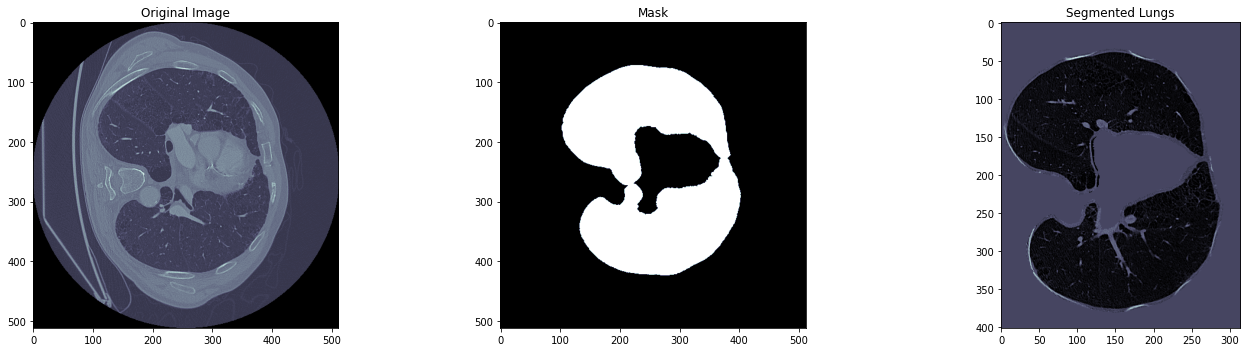

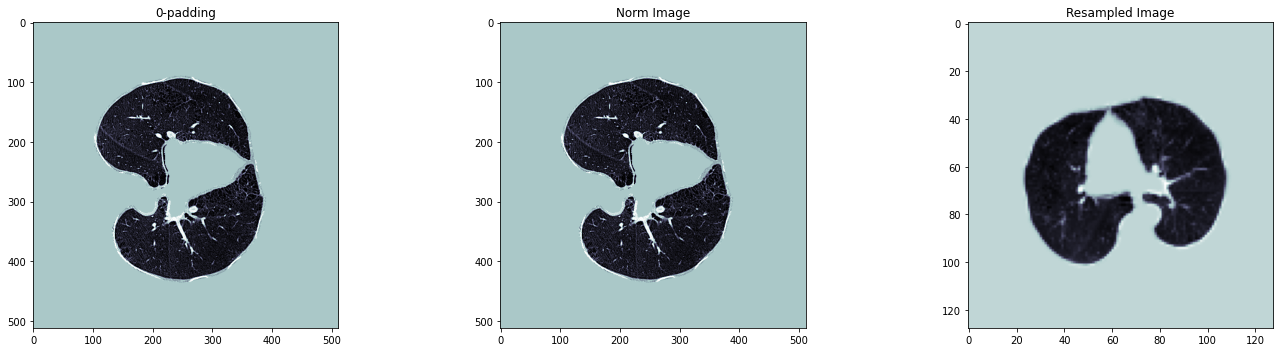

Text(0.5, 1.0, 'Sharpened Image')

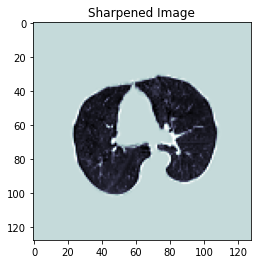

In [8]:
# Viewing the preprocessing

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20,5))
ax[0].imshow(volume[:,:,120],cmap='bone')
ax[0].set_title("Original Image")
ax[1].imshow(mask_volume_temp[120],cmap='bone')
ax[1].set_title("Mask")
ax[2].imshow(volume1[:,:,120],cmap="bone")
ax[2].set_title("Segmented Lungs")
plt.show()
plt.close()

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20,5))
ax[0].imshow(volume2[:,:,120],cmap='bone')
ax[0].set_title("0-padding")
ax[1].imshow(volume2[:,:,120],cmap='bone')
ax[1].set_title("Norm Image")
ax[2].imshow(volume4[:,:,37],cmap="bone")
ax[2].set_title("Resampled Image")
plt.show()
plt.close()

plt.imshow(volume5[:,:,37],cmap="bone")
plt.title("Sharpened Image")

## Image Pre-Processing and Data Balancing

In [11]:
# Use only once
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.

# Data Balancing: By eliminating excess data of high represented class. The index 38 has
# been chosen, as no tumour segmentation is available for patients before index 38. Remember,
# we need segmentation to check our outcome is correct or not.
norecurrent_scan_paths = norecurrent_scan_paths[38:38+54]

# Few Array Declarations
norecurrent_scans  =[]
norecurrent_scan_index = []
recurrent_scans  =[]
recurrent_scan_index = []

# Preprocessing Non-Recurrent CT Scans
for path in norecurrent_scan_paths:
   norecurrent_scans.append(process_scan(path))
   norecurrent_scan_index.append(path[-14:][0:7])

# Saving the data for future usage
np.save('norecurrent_scans_solo', norecurrent_scans)
np.save('norecurrent_scans_solo_index', norecurrent_scan_index)

# Preprocessing Recurrent CT Scans
for path in recurrent_scan_paths:
   recurrent_scans.append(process_scan(path))
   recurrent_scan_index.append(path[-14:][0:7])
   
# Saving the data for future usage
np.save('recurrent_scans_solo', recurrent_scans)
np.save('recurrent_scans_solo_index', recurrent_scan_index)

processing: /gwpool/users/tsaha/code/DataMos/CT-0/AMC-014.nii.gz
Normalizing started
Normalizing ended


resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/R01-154.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/R01-097.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/AMC-023.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/AMC-019.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/R01-162.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/AMC-046.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/R01-137.nii.gz
Normalizing started
Normalizing ended
resizing completed
processing: /gwpool/users/tsaha/code/DataMos/CT-0/R01-110.nii.gz
Normalizing started
Normalizing ended
resizing completed
proce

## Data Loading

In [5]:
# Use everytime kernal crashes

recurrent_scans_index = np.load('/gwpool/users/tsaha/code/recurrent_scans_solo_index.npy')
norecurrent_scans_index = np.load('/gwpool/users/tsaha/code/norecurrent_scans_solo_index.npy')

In [6]:
# Use everytime kernal crashes

recurrent_scans = np.load('/gwpool/users/tsaha/code/recurrent_scans_solo.npy').astype(np.float32)
norecurrent_scans = np.load('/gwpool/users/tsaha/code/norecurrent_scans_solo.npy').astype(np.float32)

## Creation of the Test Set

In [7]:
# Select 5 patients' CT scans from norecurrent_scans
selected_norecurrent_scans = norecurrent_scans[:5]
selected_norecurrent_labels = np.zeros(5)
selected_norecurrent_scans_index = norecurrent_scans_index[:5]

# # Remove the selected patients from norecurrent_scans
norecurrent_scans = norecurrent_scans[5:]
norecurrent_scans_index = norecurrent_scans_index[5:]

# # Select 5 patients' CT scans from recurrent_scans
selected_recurrent_scans = recurrent_scans[:5]
selected_recurrent_scans_index = recurrent_scans_index[:5]
selected_recurrent_labels = np.ones(5)

# # Remove the selected patients from recurrent_scans
recurrent_scans = recurrent_scans[5:]
recurrent_scans_index = recurrent_scans_index[5:]

# # Create the third array by concatenating the selected scans
x_test = np.concatenate([selected_norecurrent_scans, selected_recurrent_scans], axis=0)
y_test = np.concatenate([selected_norecurrent_labels, selected_recurrent_labels], axis=0)
x_test_index = np.concatenate([selected_norecurrent_scans_index, selected_recurrent_scans_index], axis=0)

# Saving the data for future usage
np.save('x_test', x_test.astype(np.float32))
np.save('y_test', y_test.astype(np.float32))

# Verify the shapes of the arrays after the operations
print("Shape of norecurrent_scans:", norecurrent_scans.shape)
print("Shape of recurrent_scans:", recurrent_scans.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of norecurrent_scans: (49, 128, 128, 64)
Shape of recurrent_scans: (49, 128, 128, 64)
Shape of x_test: (10, 128, 128, 64)
Shape of y_test: (10,)


## Creation of Validation Set

In [8]:
# Select 5 patients' CT scans from norecurrent_scans
selected_norecurrent_scans = norecurrent_scans[:3]
selected_norecurrent_labels = np.zeros(3)
selected_norecurrent_scans_index = norecurrent_scans_index[:3]

# Remove the selected patients from norecurrent_scans
norecurrent_scans = norecurrent_scans[3:]
norecurrent_scans_index = norecurrent_scans_index[3:]

# Select 5 patients' CT scans from recurrent_scans
selected_recurrent_scans = recurrent_scans[:3]
selected_recurrent_scans_index = recurrent_scans_index[:3]
selected_recurrent_labels = np.ones(3)

# Remove the selected patients from recurrent_scans
recurrent_scans = recurrent_scans[3:]
recurrent_scans_index = recurrent_scans_index[3:]

# Create the third array by concatenating the selected scans
x_val = np.concatenate([selected_norecurrent_scans, selected_recurrent_scans], axis=0)
y_val = np.concatenate([selected_norecurrent_labels, selected_recurrent_labels], axis=0)
x_val_index = np.concatenate([selected_norecurrent_scans_index, selected_recurrent_scans_index], axis=0)

# Verify the shapes of the arrays after the operations
print("Shape of norecurrent_scans:", norecurrent_scans.shape)
print("Shape of recurrent_scans:", recurrent_scans.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of norecurrent_scans: (46, 128, 128, 64)
Shape of recurrent_scans: (46, 128, 128, 64)
Shape of x_test: (10, 128, 128, 64)
Shape of y_test: (10,)
Shape of x_val: (6, 128, 128, 64)
Shape of y_val: (6,)


## Creation of the Training Set

In [9]:
# For the CT scans having recurrent lang cancer
# assign 1, for the non recurrent ones assign 0.
recurrent_labels = np.array([1 for _ in range(len(recurrent_scans))])
norecurrent_labels = np.array([0 for _ in range(len(norecurrent_scans))])

In [10]:
x_train = np.concatenate([norecurrent_scans, recurrent_scans], axis=0)
y_train = np.concatenate([norecurrent_labels, recurrent_labels], axis=0)
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of x_train: (92, 128, 128, 64)
Shape of y_train: (92,)


## Defining Data-Loaders

In [11]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 5

train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .batch(batch_size)
    .prefetch(2)
)

## Designing The Actual Neural Network

In [20]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Resume Training Mechanism (If training fails)

In [17]:
# Use it when the training halts unexpedtedly
resumed_epochs = 20
# Reload the last best weights when training stops accidently
model = load_model("/gwpool/users/tsaha/code/model/Round 5(final)/my3DCNN1.keras")

## Training Begins

In [ ]:
# set the basic hyperparameters

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=False,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "my3DCNN1.keras", save_best_only=True
)

# Train the model, doing validation at the end of each epoch
epochs = 200

model.fit(train_dataset,
    validation_data=validation_dataset,
    # The class weights go here
    # class_weight=weights,
    epochs=epochs - resumed_epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],)

print("Training Completed Successfully!!")

##  Plot the losses

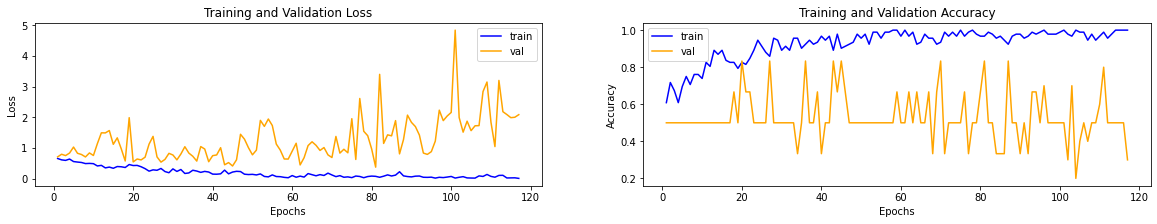

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Load the Test Set

In [53]:
# Use everytime kernal crashes

x_test = np.load('/gwpool/users/tsaha/code/x_test.npy').astype(np.float32)
y_test = np.load('/gwpool/users/tsaha/code/y_test.npy').astype(np.float32)

## Performance Testing

  Patient Name   Ground Truth Model Prediction
0      AMC-014  non-recurrent    non-recurrent
1      R01-154  non-recurrent    non-recurrent
2      R01-097  non-recurrent        recurrent
3      AMC-023  non-recurrent    non-recurrent
4      AMC-019  non-recurrent    non-recurrent
5      R01-099      recurrent        recurrent
6      AMC-005      recurrent        recurrent
7      R01-088      recurrent        recurrent
8      R01-091      recurrent        recurrent
9      R01-111      recurrent    non-recurrent


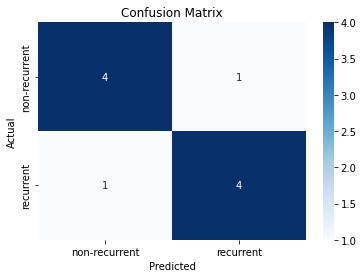

Accuracy of the model:0.8
Sensitivity: 0.8
Specificity:0.8
ROC :0.8
Balanced Accuracy:0.8
F1 Score of the Model:0.8


In [54]:
# Setting the threshold
threshold = 0.5

# Get the Prediction on the Test Set
def getPredictedClass (index):
    # Load best weights.
    model.load_weights("/gwpool/users/tsaha/code/model/Round 5(final)/my3DCNN1.keras")
    prediction = model.predict(np.expand_dims(x_test[index], axis=0))[0]
    scores = [1 - prediction[0], prediction[0]]
    # print(f'scores is {scores}')
    predictedClass = 0

    if (scores[0] > threshold) :
        predictedClass = 0
    elif (scores[1] > threshold):
        predictedClass = 1
    return predictedClass

prediction = []
for i in range(x_test.shape[0]):
    prediction.append(getPredictedClass(i))


y_true = np.array(y_test)
y_pred =  np.array(prediction)

# Just a Tabular Viewing of the outcome
df = pd.DataFrame({
    'Patient Name': x_test_index,
    'Ground Truth': np.where(y_true == 0, "non-recurrent", "recurrent"),
    'Model Prediction': np.where(y_pred == 0, "non-recurrent", "recurrent")
})
print(df)

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
labelz = np.unique(y_true)
# Mapping dictionary
mapping_dict = {0: "non-recurrent", 1: "recurrent"}
# vectorized function
vectorized_function = np.vectorize(lambda x: mapping_dict[x])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=vectorized_function(labelz), 
    yticklabels=vectorized_function(labelz))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show the various metrics we are using to measure the performance of the model
roc = roc_auc_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
npos = np.array(y_true).sum()
nneg = np.array(y_true).size - npos
sensitivity = tp / npos
specificity = tn / nneg
f1score = tp/(tp+(0.5*(fp+fn)))

print(f'Accuracy of the model:{round(acc,2)}')
print(f'Sensitivity: {round(sensitivity,2)}')
print(f'Specificity:{round(specificity,2)}')
print(f'ROC :{round(roc,2)}')
print(f'Balanced Accuracy:{round(bal_acc,2)}')
print(f'F1 Score of the Model:{round(f1score,2)}')

# 3D-Gradcam (Explainability)

## For Patient R01-088

In [29]:
# Take the last conv layer
last_conv_layer_name = 'conv3d_3'

# For patient R01-088
volume_size = x_test[7].shape
input_vol = x_test[7]

## HeatMap Generation

In [ ]:
# Remove last layer's activation
model.load_weights("/gwpool/users/tsaha/code/model/Round 5(final)/my3DCNN1.keras")
model.layers[-1].activation = None

# Print what the top predicted class is
img_array = np.expand_dims(input_vol, axis=0)

preds = model.predict(img_array)
print('Predicted:', preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

resized_heatmap = get_resized_heatmap(heatmap, volume_size)

## Preprocessing Segmentation

In [38]:
# Since Gradcam works on local explanablity, so we are explaining how R01-88 here. Hence, we
# do similar preprocessing for the segmentation available so that we can get the exact slice needed
# to identify the tmour

ct,vol = read_nifti_file('/gwpool/users/tsaha/code/seg/CT-1/R01-088.nii.gz')
volume = normalize(vol)
# Resize width, height and depth
volume = resample(ct,volume)
# volume = resample(volume)
volume = sharpen_volume(volume)

Normalizing started
Normalizing ended


resizing completed


## Visualization of heatmap on a single slice

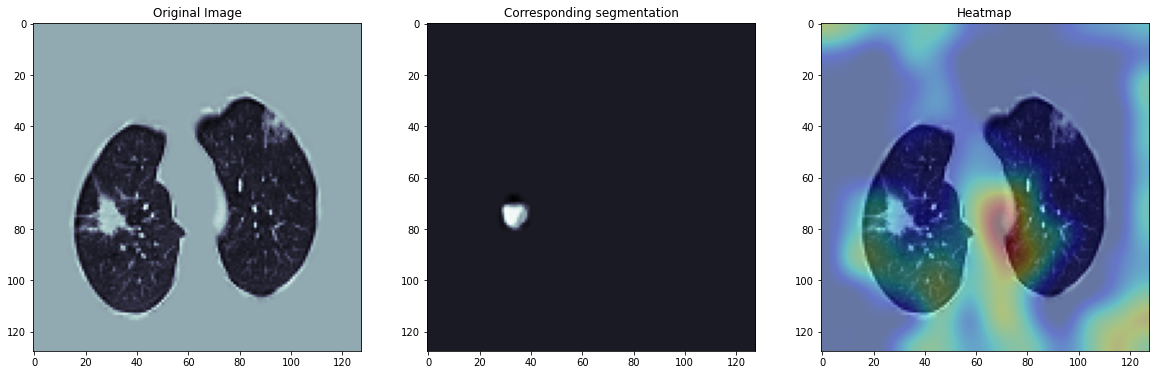

In [52]:
# Visualization of the heatmap on a single slice

fig, ax = plt.subplots(1, 3, figsize=(20, 30))
i = 49

ax[0].imshow(np.squeeze(input_vol[:, :, i]), cmap='bone')
ax[0].set_title("Original Image")
ax[1].imshow(np.squeeze(volume[:, :, i]), cmap='bone')
ax[1].set_title("Corresponding segmentation")
ax[2].set_title("Heatmap")
img0 = ax[2].imshow(np.squeeze(input_vol[:, :, i]), cmap='bone')
img1 = ax[2].imshow(np.squeeze(resized_heatmap[:, :, i]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

## Visualization on entire volume

In [34]:
viewVideo(input_vol, 'Test',heatmap=resized_heatmap)